In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import tqdm
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import wandb

from utils import *
from train import *

# for tensorboard
from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()

# Using embedding
In this experiment, we sample data not only from uniform distribution but from variety of distributions. We then use this data for encoder and feed its output throught cross-attention mechanism to the decoder. The decoder takes the sequence with missing tokens and tries to fill in the gaps.

### Architecture
- We use multihead attention for the encoder and vanilla attention for the decoder.
- In the encoder, before splitting heads I "merge" the 5 sequences through linear layer.

In [2]:
import os
print(os.getcwd())

/Users/mariayuffa/semester-project-1


In [3]:
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 0
chains_train[final_chains_train==1] = 1
#dec_samples_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 0
chains_test[final_chains_test==1] = 1
#dec_samples_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_test = np.zeros((1000,5,200))
for i in range(1,6):
    final_chains_encoder_train[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_train_{i}.npy')
    final_chains_encoder_test[:,i-1,:] = np.load(f'data/2_spin/cluster_ising/final_chains_T=1_num_iters=5_J_experiment_test_{i}.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 0
samples_train[final_chains_encoder_train==1] = 1
samples_train = samples_train.reshape((5000,200))
#enc_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 0
samples_test[final_chains_encoder_test==1] = 1
samples_test = samples_test.reshape((5000,200))
#print(samples_test.shape)
#enc_samples_test = torch.tensor(samples_test, dtype=torch.long)


Loaded train sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded test sequences of proteins sampled from Boltzmann distribution: (1000, 200)
Loaded train sequences of proteins for encoder distribution: (1000, 5, 200)
Loaded test sequences of proteins for encoder distribution: (1000, 5, 200)


In [4]:
batch_size = 32
enc_train_loader, enc_test_loader = create_dataloaders(samples_train, samples_test, batch_size, flag_float=False)
dec_train_loader, dec_test_loader = create_dataloaders(chains_train, chains_test, batch_size, flag_float=False)

In [5]:
'''
# Sequences for decoder
final_chains_train = np.load('data/final_chains_T=1_num_iters=20_J_experiment_train.npy')
chains_train = final_chains_train.copy()
chains_train[final_chains_train==-1] = 1
chains_train[final_chains_train==1] = 3
tensor_chains_train = torch.tensor(chains_train, dtype=torch.long)
print("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)

final_chains_test = np.load('data/final_chains_T=1_num_iters=20_J_experiment_test.npy')
chains_test = final_chains_test.copy()
chains_test[final_chains_test==-1] = 1 
chains_test[final_chains_test==1] = 3 
tensor_chains_test = torch.tensor(chains_test, dtype=torch.long)
print("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)


# Sequences for encoder
k = 0
final_chains_encoder_train = np.zeros((1000,5,200))
final_chains_encoder_train[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
final_chains_encoder_test = np.zeros((1000,5,200))
final_chains_encoder_test[:,0,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy') 
for i in range(20,100,20):
    k+=1
    final_chains_encoder_train[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_train.npy')
    final_chains_encoder_test[:,k,:] = np.load('data/2_spin/final_chains_T=1_num_iters=400_J='+str(i)+'_test.npy') 

print("Loaded train sequences of proteins for encoder distribution:", final_chains_encoder_train.shape)
print("Loaded test sequences of proteins for encoder distribution:", final_chains_encoder_test.shape)

samples_train = final_chains_encoder_train.copy() 
samples_train[final_chains_encoder_train==-1] = 1
samples_train[final_chains_encoder_train==1] = 3
tensor_samples_train = torch.tensor(samples_train, dtype=torch.long)

samples_test = final_chains_encoder_test.copy()
samples_test[final_chains_encoder_test==-1] = 1
samples_test[final_chains_encoder_test==1] = 3
tensor_samples_test = torch.tensor(samples_test, dtype=torch.long)
'''

'\n# Sequences for decoder\nfinal_chains_train = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_train.npy\')\nchains_train = final_chains_train.copy()\nchains_train[final_chains_train==-1] = 1\nchains_train[final_chains_train==1] = 3\ntensor_chains_train = torch.tensor(chains_train, dtype=torch.long)\nprint("Loaded train sequences of proteins sampled from Boltzmann distribution:", final_chains_train.shape)\n\nfinal_chains_test = np.load(\'data/final_chains_T=1_num_iters=20_J_experiment_test.npy\')\nchains_test = final_chains_test.copy()\nchains_test[final_chains_test==-1] = 1 \nchains_test[final_chains_test==1] = 3 \ntensor_chains_test = torch.tensor(chains_test, dtype=torch.long)\nprint("Loaded test sequences of proteins sampled from Boltzmann distribution:", final_chains_test.shape)\n\n\n# Sequences for encoder\nk = 0\nfinal_chains_encoder_train = np.zeros((1000,5,200))\nfinal_chains_encoder_train[:,0,:] = np.load(\'data/2_spin/final_chains_T=1_num_iters=400_J=10_test.npy\

In [6]:
class Transformer(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout, num_distr=5):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(num_spins, embed_dim)
        self.decoder_embedding = nn.Embedding(num_spins, embed_dim)

        #self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        #self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.positional_encoding = PositionalEncoding(embed_dim, max_seq_length)
        self.encoder_layer = EncoderLayer(embed_dim, proj_layer_dim, dropout, num_distr)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, src, tgt):
        #src_mask, tgt_mask = self.generate_mask(src, tgt)
        #src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
        #tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))
        src_embedded = self.positional_encoding(self.encoder_embedding(src))
        tgt_embedded = self.positional_encoding(self.decoder_embedding(tgt))

        enc_output = self.encoder_layer(src_embedded)
        dec_output = self.decoder_layer(tgt_embedded, enc_output)
        output = self.fc(dec_output)
        #print("output of the transformer:", output.shape)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

## Training and validation

In [7]:
# Define the parameters 
vocab_size = 3
vocab = {0:0,1:1,2:2} 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-2
num_sequences = 1000
num_epochs = 50
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


### Tracking the results

In [8]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }
)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: marindigen. Use `wandb login --relogin` to force relogin


In [9]:
# Example usage:

model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

#train(model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
path = 'runs/embedding_run_5_(1,3)'
training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)
#torch.save(model.state_dict(), 'models/lstm_scratch.pt')
#evaluate(model, test_dataloader, criterion, device=device)
wandb.finish()

  0%|          | 0/50 [00:00<?, ?it/s]/Users/mariayuffa/semester-project-1/train.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_seq_enc = torch.tensor(input_seq_enc, dtype=torch.long)
/Users/mariayuffa/semester-project-1/utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_sequences, dtype=torch.long), masked_positions
 20%|██        | 32/157 [00:03<00:14,  8.82it/s]


Epoch 1 | Train Loss: 0.9482


  2%|▏         | 1/50 [00:04<04:04,  4.99s/it]

Epoch 1 | Eval Loss: 0.1527


 20%|██        | 32/157 [00:03<00:14,  8.77it/s]


Epoch 2 | Train Loss: 0.7554


  4%|▍         | 2/50 [00:09<03:55,  4.91s/it]

Epoch 2 | Eval Loss: 0.1487


 20%|██        | 32/157 [00:03<00:13,  9.41it/s]


Epoch 3 | Train Loss: 0.7040


  6%|▌         | 3/50 [00:14<03:44,  4.77s/it]

Epoch 3 | Eval Loss: 0.1420


 20%|██        | 32/157 [00:03<00:12,  9.78it/s]


Epoch 4 | Train Loss: 0.7085


  8%|▊         | 4/50 [00:19<03:36,  4.70s/it]

Epoch 4 | Eval Loss: 0.1437


 20%|██        | 32/157 [00:03<00:13,  9.01it/s]


Epoch 5 | Train Loss: 0.7041


 10%|█         | 5/50 [00:23<03:32,  4.72s/it]

Epoch 5 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:13,  9.17it/s]


Epoch 6 | Train Loss: 0.7048


 12%|█▏        | 6/50 [00:28<03:27,  4.71s/it]

Epoch 6 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:13,  9.17it/s]


Epoch 7 | Train Loss: 0.7024


 14%|█▍        | 7/50 [00:33<03:21,  4.69s/it]

Epoch 7 | Eval Loss: 0.1437


 20%|██        | 32/157 [00:03<00:13,  9.17it/s]


Epoch 8 | Train Loss: 0.7067


 16%|█▌        | 8/50 [00:37<03:17,  4.70s/it]

Epoch 8 | Eval Loss: 0.1416


 20%|██        | 32/157 [00:03<00:13,  9.15it/s]


Epoch 9 | Train Loss: 0.7001


 18%|█▊        | 9/50 [00:42<03:12,  4.70s/it]

Epoch 9 | Eval Loss: 0.1419


 20%|██        | 32/157 [00:03<00:12,  9.73it/s]


Epoch 10 | Train Loss: 0.6976


 20%|██        | 10/50 [00:46<03:04,  4.61s/it]

Epoch 10 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.71it/s]


Epoch 11 | Train Loss: 0.6969


 22%|██▏       | 11/50 [00:51<02:57,  4.56s/it]

Epoch 11 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.45it/s]


Epoch 12 | Train Loss: 0.6980


 24%|██▍       | 12/50 [00:55<02:52,  4.54s/it]

Epoch 12 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:13,  8.96it/s]


Epoch 13 | Train Loss: 0.6946


 26%|██▌       | 13/50 [01:00<02:53,  4.69s/it]

Epoch 13 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:04<00:15,  7.82it/s]


Epoch 14 | Train Loss: 0.6969


 28%|██▊       | 14/50 [01:06<02:55,  4.87s/it]

Epoch 14 | Eval Loss: 0.1417


 20%|██        | 32/157 [00:03<00:13,  8.94it/s]


Epoch 15 | Train Loss: 0.6991


 30%|███       | 15/50 [01:10<02:48,  4.82s/it]

Epoch 15 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.55it/s]


Epoch 16 | Train Loss: 0.6973


 32%|███▏      | 16/50 [01:15<02:40,  4.73s/it]

Epoch 16 | Eval Loss: 0.1429


 20%|██        | 32/157 [00:03<00:13,  9.38it/s]


Epoch 17 | Train Loss: 0.6980


 34%|███▍      | 17/50 [01:20<02:34,  4.67s/it]

Epoch 17 | Eval Loss: 0.1414


 20%|██        | 32/157 [00:03<00:13,  9.57it/s]


Epoch 18 | Train Loss: 0.6958


 36%|███▌      | 18/50 [01:24<02:28,  4.63s/it]

Epoch 18 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:13,  9.57it/s]


Epoch 19 | Train Loss: 0.6942


 38%|███▊      | 19/50 [01:29<02:24,  4.65s/it]

Epoch 19 | Eval Loss: 0.1424


 20%|██        | 32/157 [00:03<00:13,  9.47it/s]


Epoch 20 | Train Loss: 0.6941


 40%|████      | 20/50 [01:33<02:18,  4.61s/it]

Epoch 20 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.18it/s]


Epoch 21 | Train Loss: 0.6958


 42%|████▏     | 21/50 [01:38<02:13,  4.61s/it]

Epoch 21 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:12,  9.78it/s]


Epoch 22 | Train Loss: 0.6945


 44%|████▍     | 22/50 [01:42<02:07,  4.55s/it]

Epoch 22 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.61it/s]


Epoch 23 | Train Loss: 0.6967


 46%|████▌     | 23/50 [01:47<02:02,  4.52s/it]

Epoch 23 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:12,  9.77it/s]


Epoch 24 | Train Loss: 0.6941


 48%|████▊     | 24/50 [01:51<01:56,  4.49s/it]

Epoch 24 | Eval Loss: 0.1414


 20%|██        | 32/157 [00:03<00:12,  9.71it/s]


Epoch 25 | Train Loss: 0.6937


 50%|█████     | 25/50 [01:56<01:51,  4.47s/it]

Epoch 25 | Eval Loss: 0.1419


 20%|██        | 32/157 [00:03<00:12,  9.97it/s]


Epoch 26 | Train Loss: 0.6959


 52%|█████▏    | 26/50 [02:00<01:46,  4.43s/it]

Epoch 26 | Eval Loss: 0.1421


 20%|██        | 32/157 [00:03<00:14,  8.70it/s]


Epoch 27 | Train Loss: 0.6941


 54%|█████▍    | 27/50 [02:05<01:45,  4.59s/it]

Epoch 27 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:12,  9.64it/s]


Epoch 28 | Train Loss: 0.6941


 56%|█████▌    | 28/50 [02:09<01:40,  4.55s/it]

Epoch 28 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:12,  9.89it/s]


Epoch 29 | Train Loss: 0.6937


 58%|█████▊    | 29/50 [02:14<01:34,  4.51s/it]

Epoch 29 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:13,  9.61it/s]


Epoch 30 | Train Loss: 0.6944


 60%|██████    | 30/50 [02:18<01:30,  4.51s/it]

Epoch 30 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:13,  9.50it/s]


Epoch 31 | Train Loss: 0.6935


 62%|██████▏   | 31/50 [02:23<01:25,  4.51s/it]

Epoch 31 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:13,  9.53it/s]


Epoch 32 | Train Loss: 0.6957


 64%|██████▍   | 32/50 [02:27<01:21,  4.51s/it]

Epoch 32 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.62it/s]


Epoch 33 | Train Loss: 0.6939


 66%|██████▌   | 33/50 [02:32<01:16,  4.50s/it]

Epoch 33 | Eval Loss: 0.1415


 20%|██        | 32/157 [00:03<00:12,  9.81it/s]


Epoch 34 | Train Loss: 0.6940


 68%|██████▊   | 34/50 [02:36<01:12,  4.51s/it]

Epoch 34 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.71it/s]


Epoch 35 | Train Loss: 0.6945


 70%|███████   | 35/50 [02:41<01:07,  4.49s/it]

Epoch 35 | Eval Loss: 0.1416


 20%|██        | 32/157 [00:03<00:12,  9.76it/s]


Epoch 36 | Train Loss: 0.6943


 72%|███████▏  | 36/50 [02:45<01:02,  4.47s/it]

Epoch 36 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.79it/s]


Epoch 37 | Train Loss: 0.6936


 74%|███████▍  | 37/50 [02:50<00:57,  4.44s/it]

Epoch 37 | Eval Loss: 0.1416


 20%|██        | 32/157 [00:03<00:12,  9.67it/s]


Epoch 38 | Train Loss: 0.6940


 76%|███████▌  | 38/50 [02:54<00:53,  4.45s/it]

Epoch 38 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:12,  9.71it/s]


Epoch 39 | Train Loss: 0.6945


 78%|███████▊  | 39/50 [02:58<00:49,  4.45s/it]

Epoch 39 | Eval Loss: 0.1414


 20%|██        | 32/157 [00:03<00:13,  9.60it/s]


Epoch 40 | Train Loss: 0.6939


 80%|████████  | 40/50 [03:03<00:44,  4.46s/it]

Epoch 40 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.73it/s]


Epoch 41 | Train Loss: 0.6942


 82%|████████▏ | 41/50 [03:07<00:40,  4.45s/it]

Epoch 41 | Eval Loss: 0.1414


 20%|██        | 32/157 [00:03<00:14,  8.77it/s]


Epoch 42 | Train Loss: 0.6960


 84%|████████▍ | 42/50 [03:12<00:36,  4.55s/it]

Epoch 42 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.62it/s]


Epoch 43 | Train Loss: 0.6934


 86%|████████▌ | 43/50 [03:17<00:31,  4.53s/it]

Epoch 43 | Eval Loss: 0.1428


 20%|██        | 32/157 [00:03<00:12,  9.62it/s]


Epoch 44 | Train Loss: 0.6957


 88%|████████▊ | 44/50 [03:21<00:27,  4.52s/it]

Epoch 44 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:12,  9.82it/s]


Epoch 45 | Train Loss: 0.6936


 90%|█████████ | 45/50 [03:26<00:22,  4.48s/it]

Epoch 45 | Eval Loss: 0.1416


 20%|██        | 32/157 [00:03<00:12,  9.90it/s]


Epoch 46 | Train Loss: 0.6942


 92%|█████████▏| 46/50 [03:30<00:17,  4.44s/it]

Epoch 46 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.79it/s]


Epoch 47 | Train Loss: 0.6936


 94%|█████████▍| 47/50 [03:34<00:13,  4.42s/it]

Epoch 47 | Eval Loss: 0.1414


 20%|██        | 32/157 [00:03<00:12,  9.66it/s]


Epoch 48 | Train Loss: 0.6937


 96%|█████████▌| 48/50 [03:39<00:08,  4.43s/it]

Epoch 48 | Eval Loss: 0.1412


 20%|██        | 32/157 [00:03<00:12,  9.68it/s]


Epoch 49 | Train Loss: 0.6945


 98%|█████████▊| 49/50 [03:43<00:04,  4.43s/it]

Epoch 49 | Eval Loss: 0.1413


 20%|██        | 32/157 [00:03<00:13,  9.34it/s]


Epoch 50 | Train Loss: 0.6940


 20%|██        | 32/157 [00:01<00:04, 28.76it/s]


Epoch 50 | Eval Loss: 0.1412


eval_loss,█▆▁▃▁▃▁▁▁▁▁▁▂▁▁▂▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁
train_loss,▁█▄▅▅▄▃▁▅▃▄▃▂▃▄▅▆▄▅▄▅▃▃▄▃▃▃▄▃▃▃▃▄▄▂▃▄▃▄▄
eval_loss,0.1412
train_loss,0.69647


In [10]:
cross_attention_weights = model.get_cross_attention_weights()
self_attention_weights = model.get_self_attention_weights()

print("Cross-attention weights:", cross_attention_weights.shape)
print("Self-attention weights:", self_attention_weights.shape)

Cross-attention weights: torch.Size([32, 200, 200])
Self-attention weights: torch.Size([8, 200, 200])


In [11]:
# To save only the decoder layer weights
#torch.save(model.decoder_layer.state_dict(), 'model_decoder/decoder_weights_experiment_batch.pth')
#torch.save(model.get_cross_attention_weights(), 'model_decoder/transformer_cross_attn_weights_experiment_batch.pth')
#torch.save(model.get_self_attention_weights(), 'model_decoder/transformer_dec_attn_weights_experiment_batch.pth')
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights_batch.pth')

In [12]:
cross_weights = cross_attention_weights.squeeze(0).detach().cpu().numpy()
decoder_weights = self_attention_weights.squeeze(0).detach().cpu().numpy()
print(cross_weights.shape)
print(decoder_weights.shape)

(32, 200, 200)
(8, 200, 200)


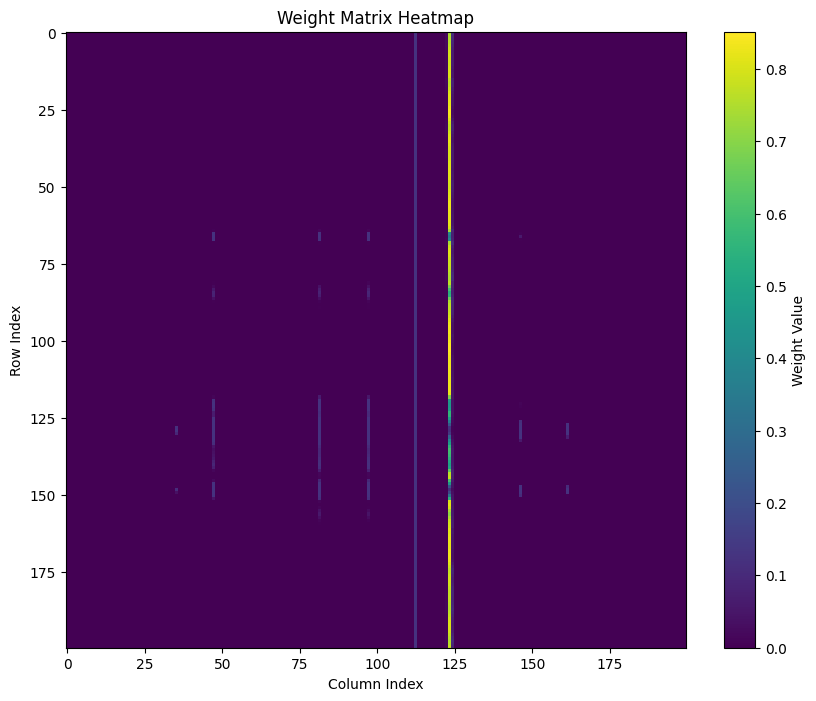

In [13]:
def generate_heatmap(weight_matrix):
    """
    Generates a heatmap from a given weight matrix.
    
    Parameters:
    weight_matrix (numpy.ndarray): A 2D numpy array of shape (200, 200) representing the weights.
    
    Returns:
    None
    """
    if weight_matrix.shape != (200, 200):
        raise ValueError("The weight matrix must be of shape (200, 200)")
    
    plt.figure(figsize=(10, 8))
    plt.imshow(weight_matrix, cmap='viridis', aspect='auto')
    plt.colorbar(label='Weight Value')
    plt.title('Weight Matrix Heatmap')
    plt.xlabel('Column Index')
    plt.ylabel('Row Index')
    plt.show()

# Example usage
#caw = decoder_weights.cpu().detach().numpy()
#generate_heatmap(cross_weights.mean(axis=0))
generate_heatmap(self_attention_weights.detach().mean(axis=0))

# Ablation study
In this study we remove the encoder when testing the model

In [14]:
# If you need to load these weights later
model = Transformer(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)
decoder_weights = torch.load('model_decoder/decoder_weights_experiment_batch.pth')
model.decoder_layer.load_state_dict(decoder_weights)

# Save the weights of the FC layer
#torch.save(model.fc.state_dict(), 'model_decoder/transformer_fc_weights.pth')

# To load these weights back into the FC layer later
fc_weights = torch.load('model_decoder/transformer_fc_weights_batch.pth')
model.fc.load_state_dict(fc_weights)

<All keys matched successfully>

In [15]:
class TransformerAblated(nn.Module):
    def __init__(self, embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout):
        super(TransformerAblated, self).__init__()
        self.word_embeddings = nn.Embedding(num_spins+1, embed_dim)
        self.decoder_layer = DecoderLayer(embed_dim, a, max_seq_length, num_spins, proj_layer_dim, dropout)
        self.fc = nn.Linear(embed_dim, num_spins)

    def forward(self, tgt):
        tgt_embedded = self.word_embeddings(tgt)
        dec_output = self.decoder_layer(tgt_embedded, tgt_embedded)
        output = self.fc(dec_output)
        return output
    
    def get_cross_attention_weights(self):
        return self.decoder_layer.cross_attn_weights
    
    def get_self_attention_weights(self):
        return self.decoder_layer.decoder_attn_weights

In [16]:
# Create an instance of the new model
new_model = TransformerAblated(embed_dim=embedding_dim, a=0, max_seq_length=L, num_spins=3, proj_layer_dim=128, dropout=dropout_rate)

# Load the saved decoder weights
decoder_weights = torch.load('model_decoder/decoder_weights.pth')
new_model.decoder_layer.load_state_dict(decoder_weights)

# Load the saved FC weights
fc_weights = torch.load('model_decoder/transformer_fc_weights.pth')
new_model.fc.load_state_dict(fc_weights)


<All keys matched successfully>

In [17]:
# Define the parameters 
L = 200
embedding_dim = 200
proj_layer_dim = 128
hidden_dim = 200
num_layers = 1 # have to adapt the model for 2 and 3 layers
dropout_rate = 0.0
lr = 1e-1
num_sequences = 1000
num_epochs = 50
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(device)

mps


In [24]:
# start a new wandb run to track this script
wandb.init(
    # set the wandb project where this run will be logged
    project="cross_attention_experiment",

    # track hyperparameters and run metadata
    config={
    "learning_rate": lr,
    "architecture": "Transformer",
    "dataset": "ms_sequences_with_different_probability",
    "epochs": num_epochs,
    }
)

In [25]:
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()
vocab = {0:0,1:1,2:2}
path = '/Users/mariayuffa/semester-project-1/runs'

#training_script(path, model, data_train=enc_train_loader, data_train_dec=dec_train_loader,
#                data_test=enc_test_loader, data_test_dec=dec_test_loader, vocab=vocab, optimizer=optimizer,
#                criterion=criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)

#loss, weights = train(model, new_model, tensor_samples_train, tensor_chains_train, tensor_samples_test, tensor_chains_test, vocab, optimizer, criterion, device=device)
loss, store_cross_attention, store_decoder_attention = training_script_ablated(path, model, new_model, enc_train_loader, dec_train_loader, enc_test_loader, dec_test_loader, vocab, optimizer, criterion, one_hot_flag=False, num_epochs=num_epochs, device=0)

  0%|          | 0/50 [00:00<?, ?it/s]/Users/mariayuffa/semester-project-1/utils.py:160: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(masked_sequences, dtype=torch.long), masked_positions
 20%|██        | 32/157 [00:03<00:15,  8.13it/s]


Epoch 1 | Train Loss: 0.9225


  2%|▏         | 1/50 [00:04<03:44,  4.57s/it]

Epoch 1 | Eval Loss: 0.7338


 20%|██        | 32/157 [00:03<00:13,  9.29it/s]


Epoch 2 | Train Loss: 0.7053


  4%|▍         | 2/50 [00:08<03:24,  4.26s/it]

Epoch 2 | Eval Loss: 0.7089


 20%|██        | 32/157 [00:03<00:13,  9.02it/s]


Epoch 3 | Train Loss: 0.7202


  6%|▌         | 3/50 [00:12<03:18,  4.22s/it]

Epoch 3 | Eval Loss: 0.6927


 20%|██        | 32/157 [00:03<00:14,  8.37it/s]


Epoch 4 | Train Loss: 0.7167


  8%|▊         | 4/50 [00:17<03:21,  4.39s/it]

Epoch 4 | Eval Loss: 0.6928


 20%|██        | 32/157 [00:03<00:13,  9.16it/s]


Epoch 5 | Train Loss: 0.7423


 10%|█         | 5/50 [00:21<03:13,  4.30s/it]

Epoch 5 | Eval Loss: 0.6935


 20%|██        | 32/157 [00:03<00:14,  8.76it/s]


Epoch 6 | Train Loss: 0.7179


 12%|█▏        | 6/50 [00:25<03:10,  4.32s/it]

Epoch 6 | Eval Loss: 0.6944


 20%|██        | 32/157 [00:03<00:14,  8.93it/s]


Epoch 7 | Train Loss: 0.7179


 14%|█▍        | 7/50 [00:30<03:04,  4.30s/it]

Epoch 7 | Eval Loss: 0.7230


 20%|██        | 32/157 [00:03<00:14,  8.62it/s]


Epoch 8 | Train Loss: 0.7199


 16%|█▌        | 8/50 [00:34<03:01,  4.32s/it]

Epoch 8 | Eval Loss: 0.7093


 20%|██        | 32/157 [00:03<00:13,  9.18it/s]


Epoch 9 | Train Loss: 0.7148


 18%|█▊        | 9/50 [00:38<02:55,  4.29s/it]

Epoch 9 | Eval Loss: 0.7648


 20%|██        | 32/157 [00:03<00:13,  9.37it/s]


Epoch 10 | Train Loss: 0.7054


 20%|██        | 10/50 [00:42<02:48,  4.21s/it]

Epoch 10 | Eval Loss: 0.6928


 20%|██        | 32/157 [00:03<00:14,  8.65it/s]


Epoch 11 | Train Loss: 0.6990


 22%|██▏       | 11/50 [00:47<02:45,  4.24s/it]

Epoch 11 | Eval Loss: 0.6956


 20%|██        | 32/157 [00:03<00:13,  9.19it/s]


Epoch 12 | Train Loss: 0.7120


 24%|██▍       | 12/50 [00:51<02:40,  4.22s/it]

Epoch 12 | Eval Loss: 0.7028


 20%|██        | 32/157 [00:03<00:13,  9.32it/s]


Epoch 13 | Train Loss: 0.7169


 26%|██▌       | 13/50 [00:55<02:34,  4.18s/it]

Epoch 13 | Eval Loss: 0.7007


 20%|██        | 32/157 [00:03<00:15,  8.00it/s]


Epoch 14 | Train Loss: 0.7616


 28%|██▊       | 14/50 [01:00<02:35,  4.32s/it]

Epoch 14 | Eval Loss: 0.8914


 20%|██        | 32/157 [00:03<00:13,  9.05it/s]


Epoch 15 | Train Loss: 0.7345


 30%|███       | 15/50 [01:04<02:29,  4.27s/it]

Epoch 15 | Eval Loss: 0.7177


 20%|██        | 32/157 [00:03<00:13,  9.15it/s]


Epoch 16 | Train Loss: 0.7400


 32%|███▏      | 16/50 [01:08<02:25,  4.28s/it]

Epoch 16 | Eval Loss: 0.7430


 20%|██        | 32/157 [00:03<00:14,  8.69it/s]


Epoch 17 | Train Loss: 0.7448


 34%|███▍      | 17/50 [01:12<02:21,  4.30s/it]

Epoch 17 | Eval Loss: 0.7558


 20%|██        | 32/157 [00:03<00:12,  9.63it/s]


Epoch 18 | Train Loss: 0.7403


 36%|███▌      | 18/50 [01:16<02:14,  4.20s/it]

Epoch 18 | Eval Loss: 0.7291


 20%|██        | 32/157 [00:03<00:12,  9.66it/s]


Epoch 19 | Train Loss: 0.7184


 38%|███▊      | 19/50 [01:20<02:07,  4.11s/it]

Epoch 19 | Eval Loss: 0.7187


 20%|██        | 32/157 [00:03<00:13,  9.35it/s]


Epoch 20 | Train Loss: 0.7182


 40%|████      | 20/50 [01:24<02:02,  4.09s/it]

Epoch 20 | Eval Loss: 0.6927


 20%|██        | 32/157 [00:03<00:13,  9.59it/s]


Epoch 21 | Train Loss: 0.7064


 42%|████▏     | 21/50 [01:28<01:57,  4.04s/it]

Epoch 21 | Eval Loss: 0.6906


 20%|██        | 32/157 [00:03<00:13,  9.34it/s]


Epoch 22 | Train Loss: 0.6959


 44%|████▍     | 22/50 [01:32<01:53,  4.05s/it]

Epoch 22 | Eval Loss: 0.6915


 20%|██        | 32/157 [00:03<00:13,  9.14it/s]


Epoch 23 | Train Loss: 0.6992


 46%|████▌     | 23/50 [01:36<01:50,  4.07s/it]

Epoch 23 | Eval Loss: 0.7364


 20%|██        | 32/157 [00:03<00:12,  9.77it/s]


Epoch 24 | Train Loss: 0.6997


 48%|████▊     | 24/50 [01:40<01:44,  4.03s/it]

Epoch 24 | Eval Loss: 0.6928


 20%|██        | 32/157 [00:03<00:13,  9.40it/s]


Epoch 25 | Train Loss: 0.7058


 50%|█████     | 25/50 [01:44<01:40,  4.02s/it]

Epoch 25 | Eval Loss: 0.7022


 20%|██        | 32/157 [00:03<00:14,  8.68it/s]


Epoch 26 | Train Loss: 0.7298


 52%|█████▏    | 26/50 [01:49<01:38,  4.12s/it]

Epoch 26 | Eval Loss: 0.8184


 20%|██        | 32/157 [00:03<00:14,  8.53it/s]


Epoch 27 | Train Loss: 0.7250


 54%|█████▍    | 27/50 [01:53<01:36,  4.21s/it]

Epoch 27 | Eval Loss: 0.7349


 20%|██        | 32/157 [00:03<00:12,  9.76it/s]


Epoch 28 | Train Loss: 0.7018


 56%|█████▌    | 28/50 [01:57<01:30,  4.13s/it]

Epoch 28 | Eval Loss: 0.6766


 20%|██        | 32/157 [00:03<00:13,  9.35it/s]


Epoch 29 | Train Loss: 0.7028


 58%|█████▊    | 29/50 [02:01<01:26,  4.11s/it]

Epoch 29 | Eval Loss: 0.7025


 20%|██        | 32/157 [00:03<00:13,  9.35it/s]


Epoch 30 | Train Loss: 0.7037


 60%|██████    | 30/50 [02:05<01:21,  4.09s/it]

Epoch 30 | Eval Loss: 0.7156


 20%|██        | 32/157 [00:03<00:13,  9.05it/s]


Epoch 31 | Train Loss: 0.7088


 62%|██████▏   | 31/50 [02:09<01:17,  4.10s/it]

Epoch 31 | Eval Loss: 0.7294


 20%|██        | 32/157 [00:03<00:13,  9.56it/s]


Epoch 32 | Train Loss: 0.7259


 64%|██████▍   | 32/50 [02:13<01:12,  4.05s/it]

Epoch 32 | Eval Loss: 0.7056


 20%|██        | 32/157 [00:03<00:12,  9.64it/s]


Epoch 33 | Train Loss: 0.8536


 66%|██████▌   | 33/50 [02:17<01:08,  4.03s/it]

Epoch 33 | Eval Loss: 0.7138


 20%|██        | 32/157 [00:03<00:13,  9.53it/s]


Epoch 34 | Train Loss: 0.7942


 68%|██████▊   | 34/50 [02:21<01:04,  4.03s/it]

Epoch 34 | Eval Loss: 1.0150


 20%|██        | 32/157 [00:03<00:12,  9.74it/s]


Epoch 35 | Train Loss: 4.6768


 70%|███████   | 35/50 [02:25<00:59,  4.00s/it]

Epoch 35 | Eval Loss: 6.3093


 20%|██        | 32/157 [00:03<00:12,  9.69it/s]


Epoch 36 | Train Loss: 1.7080


 72%|███████▏  | 36/50 [02:29<00:55,  3.98s/it]

Epoch 36 | Eval Loss: 2.2182


 20%|██        | 32/157 [00:03<00:13,  9.60it/s]


Epoch 37 | Train Loss: 0.7506


 74%|███████▍  | 37/50 [02:33<00:51,  3.97s/it]

Epoch 37 | Eval Loss: 1.2880


 20%|██        | 32/157 [00:03<00:13,  9.57it/s]


Epoch 38 | Train Loss: 0.7125


 76%|███████▌  | 38/50 [02:37<00:47,  3.97s/it]

Epoch 38 | Eval Loss: 0.9068


 20%|██        | 32/157 [00:03<00:13,  9.43it/s]


Epoch 39 | Train Loss: 0.7019


 78%|███████▊  | 39/50 [02:41<00:43,  3.98s/it]

Epoch 39 | Eval Loss: 1.0146


 20%|██        | 32/157 [00:03<00:13,  9.45it/s]


Epoch 40 | Train Loss: 0.6980


 80%|████████  | 40/50 [02:45<00:39,  3.99s/it]

Epoch 40 | Eval Loss: 1.1036


 20%|██        | 32/157 [00:03<00:12,  9.76it/s]


Epoch 41 | Train Loss: 0.7001


 82%|████████▏ | 41/50 [02:49<00:35,  3.97s/it]

Epoch 41 | Eval Loss: 1.0170


 20%|██        | 32/157 [00:03<00:12,  9.64it/s]


Epoch 42 | Train Loss: 0.7002


 84%|████████▍ | 42/50 [02:53<00:31,  3.96s/it]

Epoch 42 | Eval Loss: 1.2706


 20%|██        | 32/157 [00:03<00:13,  9.59it/s]


Epoch 43 | Train Loss: 0.7029


 86%|████████▌ | 43/50 [02:57<00:27,  3.97s/it]

Epoch 43 | Eval Loss: 1.0538


 20%|██        | 32/157 [00:03<00:13,  9.59it/s]


Epoch 44 | Train Loss: 0.7019


 88%|████████▊ | 44/50 [03:01<00:23,  3.96s/it]

Epoch 44 | Eval Loss: 1.0942


 20%|██        | 32/157 [00:03<00:14,  8.87it/s]


Epoch 45 | Train Loss: 0.7025


 90%|█████████ | 45/50 [03:05<00:20,  4.05s/it]

Epoch 45 | Eval Loss: 0.9907


 20%|██        | 32/157 [00:03<00:13,  9.16it/s]


Epoch 46 | Train Loss: 0.6928


 92%|█████████▏| 46/50 [03:09<00:16,  4.07s/it]

Epoch 46 | Eval Loss: 0.9774


 20%|██        | 32/157 [00:03<00:13,  9.38it/s]


Epoch 47 | Train Loss: 0.6966


 94%|█████████▍| 47/50 [03:13<00:12,  4.10s/it]

Epoch 47 | Eval Loss: 0.9653


 20%|██        | 32/157 [00:03<00:13,  9.38it/s]


Epoch 48 | Train Loss: 0.6962


 96%|█████████▌| 48/50 [03:17<00:08,  4.09s/it]

Epoch 48 | Eval Loss: 0.8724


 20%|██        | 32/157 [00:03<00:13,  9.30it/s]


Epoch 49 | Train Loss: 0.6966


 98%|█████████▊| 49/50 [03:21<00:04,  4.08s/it]

Epoch 49 | Eval Loss: 0.8721


 20%|██        | 32/157 [00:03<00:13,  9.38it/s]


Epoch 50 | Train Loss: 0.6963


100%|██████████| 32/32 [00:00<00:00, 52.49it/s]
                                               

Epoch 50 | Eval Loss: 1.0159


TypeError: cannot unpack non-iterable NoneType object

In [20]:
wandb.finish()

eval_loss,█▁▁▂▄▄▃▅▄▃▅▃▄▄▃▄▄▄▅▄▄▆▄▅▄▄▄▄▄▃▅▇▄▄▄▅▄▅▄▄
train_loss,▂▃▃▃▂▂▂▂▂▅▂▂▃▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▃▃█▂▃▂▂▃▂▄▃
eval_loss,0.7052
train_loss,0.74737


# Extracting activations

In [22]:
# loading self-attention weights
#cross_attention_weights = torch.load('model_decoder/transformer_cross_attn_weights.pth')
#cross_attention_weights = new_model.get_cross_attention_weights()
#self_attention_weights = new_model.get_self_attention_weights()

print("Cross-attention weights:", cross_attention_weights.shape)
print("Self-attention weights:", self_attention_weights.shape)

Cross-attention weights: torch.Size([8, 200, 200])
Self-attention weights: torch.Size([8, 200, 200])


In [17]:
generate_heatmap(cross_attention_weights.mean(0).detach().numpy())

NameError: name 'generate_heatmap' is not defined

In [ ]:
generate_heatmap(self_attention_weights.mean(0).detach().numpy())